In [2]:
# To check if GPU is connected or not
import tensorflow as tf
tf.test.gpu_device_name()

''

# Fetching the data

In [3]:
# Mounting the google drive for data storage
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Fetching the zip file and saving it into drive
# !wget 'http://www.cl.cam.ac.uk/Research/NL/nl-download/GenSpam.tar.gz' -P drive/MyDrive/datasets/
# !wget 'https://spamassassin.apache.org/old/publiccorpus/20050311_spam_2.tar.bz2' -P drive/MyDrive/datasets/
!wget 'http://nlp.cs.aueb.gr/software_and_datasets/Enron-Spam/preprocessed/enron6.tar.gz' -P drive/MyDrive/datasets/
# !wget 'http://nlp.cs.aueb.gr/software_and_datasets/lingspam_public.tar.gz' -P drive/MyDrive/datasets/

--2024-10-07 20:33:41--  http://www.cl.cam.ac.uk/Research/NL/nl-download/GenSpam.tar.gz
Resolving www.cl.cam.ac.uk (www.cl.cam.ac.uk)... 128.232.0.20, 2a05:b400:110::80:14
Connecting to www.cl.cam.ac.uk (www.cl.cam.ac.uk)|128.232.0.20|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.cl.cam.ac.uk/Research/NL/nl-download/GenSpam.tar.gz [following]
--2024-10-07 20:33:41--  https://www.cl.cam.ac.uk/Research/NL/nl-download/GenSpam.tar.gz
Connecting to www.cl.cam.ac.uk (www.cl.cam.ac.uk)|128.232.0.20|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cl.cam.ac.uk/research/nl/nl-download/GenSpam.tar.gz [following]
--2024-10-07 20:33:42--  https://www.cl.cam.ac.uk/research/nl/nl-download/GenSpam.tar.gz
Reusing existing connection to www.cl.cam.ac.uk:443.
HTTP request sent, awaiting response... 200 OK
Length: 10560985 (10M) [application/x-gzip]
Saving to: ‘drive/MyDrive/datasets/GenSpam.tar.gz’

GenSpam

In [ ]:
# Unzipping the zip file
!tar -xvzf drive/MyDrive/datasets/enron6.tar.gz -C drive/MyDrive/datasets/

# Install Necessary Libraries

In [ ]:
! pip install nltk torch transformers tensorflow-text --quiet

# Extracting the Data from the .txt files

In [7]:
data_dir = '/content/drive/MyDrive/datasets/enron6'
spam_dir = f'{data_dir}/spam'
ham_dir = f'{data_dir}/ham'

In [ ]:
# Getting the list of spam and ham .txt files from Enron data set
import os

def get_txt_files(directory):
  """Gets a list of all .txt files in a directory."""
  txt_files = []
  for root, _, files in os.walk(directory):
    for file in files:
      if file.endswith(".txt"):
        txt_files.append(os.path.join(root, file))
  return txt_files

spam_files = get_txt_files(spam_dir)
ham_files = get_txt_files(ham_dir)


In [ ]:
import pandas as pd
from tqdm import tqdm
import sys

# Extracting Spam and Ham Data
spam_data = []
ham_data = []

for spam_file in tqdm(spam_files, file=sys.stdout, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}"):
  with open(spam_file, 'r', encoding='latin-1') as f:
    spam_content = f.read()
    spam_data.append({'content':spam_content, 'is_spam':1})

for ham_file in tqdm(ham_files):
  with open(ham_file, 'r', encoding='latin-1') as f:
    ham_content = f.read()
    ham_data.append({'content':ham_content, 'is_spam':0})

# Concating spam and ham data
data = pd.concat([pd.DataFrame(spam_data), pd.DataFrame(ham_data)])

# Shuffle Data
data = data.sample(frac=1).reset_index(drop=True)

In [ ]:
# Checkpoint 1 - Saving the raw data to the .csv file
data_extracted = data.copy()
data_extracted.to_csv(f'{data_dir}/data_extracted.csv', index=False, escapechar='\\')

In [30]:
import pandas as pd
pd.set_option('display.max_columns', None)

data = pd.read_csv(f'{data_dir}/data_extracted.csv')
data.sample(10)    # Fetching random 3 samples

,content,is_spam
5880,Subject: are you a savvy investor ?\nrocket st...,1
5888,Subject: h : eyeforenergy briefing\n,0
3794,Subject: finest online pills here\naffiance el...,1
498,Subject: install the most popular computer ope...,1
4548,Subject: save my soul\nfrom : abacha ` s famil...,1
834,Subject: refinance - now even with bad - credi...,1
2747,"Subject: seemed ado 0 be , allas , plnnacle sy...",1
4685,"Subject: re : account # 41826 d\nhello ,\nwe s...",1
3752,Subject: competing pipelines\nomaha facility p...,0
4425,Subject: hello from anna : )\nhello dear frind...,1


Since this is only textual data, there not much to perform EDA on

# Class Imbalance

In [ ]:
# Checking the class imbalance
value_counts = data['is_spam'].value_counts()
value_counts

,count
is_spam,
1,4500
0,1500


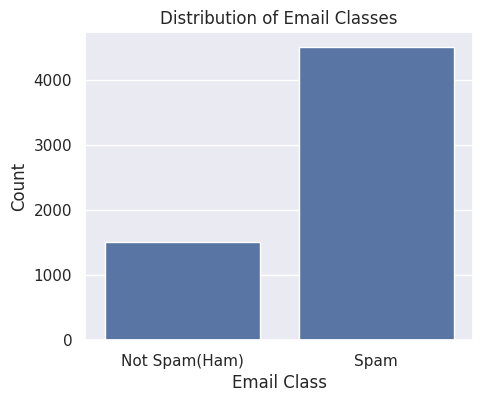

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
sns.set_theme(style="darkgrid")
sns.countplot(x='is_spam', data=data)

plt.xticks([0, 1], ['Not Spam(Ham)', 'Spam'])

plt.xlabel('Email Class')
plt.ylabel('Count')
plt.title('Distribution of Email Classes')
plt.show()


There are many spam email samples compared to not spam and since I'm using BERT model for training and prediction, 1500 samples are enough for both the categories since transformers are good at context detection.

In [ ]:
print(f"Percentage of data that needs to be managed: {round(value_counts[0] / value_counts[1], 2)} %")

Percentage of data that needs to be managed: 0.33 %


In [25]:
# Downsampling the spam emails data
data_spam = data[data['is_spam'] == 1]
data_ham = data[data['is_spam'] == 0]

data_spam_downsampled = data_spam.sample(n=len(data_ham), random_state=42)
data = pd.concat([data_spam_downsampled, data_ham])
data = data.sample(frac=1).reset_index(drop=True)

In [26]:
data['is_spam'].value_counts()

,count
is_spam,
1,1500
0,1500


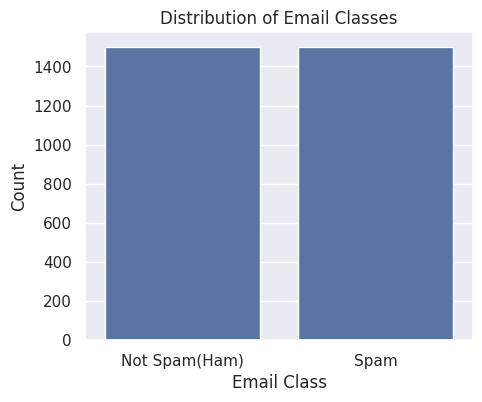

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
sns.set_theme(style="darkgrid")
sns.countplot(x='is_spam', data=data)

plt.xticks([0, 1], ['Not Spam(Ham)', 'Spam'])

plt.xlabel('Email Class')
plt.ylabel('Count')
plt.title('Distribution of Email Classes')
plt.show()

In [ ]:
# Checkpoint 2 - Saving the resolve class imbalance data
data_balanced = data.copy()
data_balanced.to_csv(f'{data_dir}/data_balanced.csv', index=False, escapechar='\\')

# Text Processing

Here I'm doing basic text processing which includes:
- Make all the text of email lower case
- Removal of any URLs and HTML tags from the email text
- Removal of non-alphanumeric characters

Since BERT and other transformer based neural networks are good a context understanding, there's no need to perform lemmatization and stop words removal.

In [ ]:
import re

# processing text with ReGex
def process_text(text):
  # Convert to lower case
  text = text.lower()

  # Remove URLS
  text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

  # Remove HTML tags
  text = re.sub(r'<.*?>', '', text)

  # Remove non-alphanumeric characters and extra spaces
  text = re.sub(r'\W+', ' ', text)
  text = re.sub(r'\s+', ' ', text).strip()

  return text


data['content'] = data['content'].apply(process_text)

In [ ]:
# Checkpoint 2 - Text Processing
data_text_processed = data.copy()
data_text_processed.to_csv(f'{data_dir}/data_text_processed.csv', index=False, escapechar='\\')

# Training and Testing Data Split

In [8]:
# To directly import processed data
import pandas as pd
data = pd.read_csv(f'{data_dir}/data_text_processed.csv')

In [ ]:
data.sample(5).iloc[0]['content']

'subject set up michelle ok we are all set up we are going to do a snow shoe trip on tuesday at 10 30 a m for 2 hours supposedly easy trail just enough to work up a sweat then we are going to drive 45 minute scenic drive to hot springs co probably have time for a lunch our messages are set up for 3 00 p m and we get to soak in any one of 21 sulphur pools at our leisure sounds divine doesn t it since they have to put salt on the pavement the guy suggested that we bring our own flip flops he says we can rent towels and robes but if i remember i ll bring them for us as backups if they don t have any available so looks like you just need warm clothing and flip flops oh yeah do you have a warm pair of boots we can rent the snowshoing equipment but we have to have a good pair of warm boots if you don t think you have a pair let me know and i can bring an extra pair along hopefully they won t be too big for your tiny feet but boots are usually big anyway just wear lots of socks let me know te

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['content'], data['is_spam'],\
                                                    test_size=0.2, random_state=42)

# Preparing Model - Finetuning BERT

For Finetuning, I will be using transformers library developed by [Hugging Face](https://huggingface.co/docs/transformers/en/index)

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the dataset
def tokenize_data(text_list, max_length=128):
    return tokenizer(
        text_list,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt')

train_encodings = tokenize_data(X_train.tolist())
test_encodings = tokenize_data(X_test.tolist())

# Convert labels to tensors
y_train = torch.tensor(y_train.values)
y_test = torch.tensor(y_test.values)

# Load the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

# Training the model
__Note__: Training the model on a CPU may take more than hour. So, it is desired to use the GPU on google colab.

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from transformers import AdamW
from tqdm import tqdm
import time

# Create a dataset object
train_dataset = TensorDataset(train_encodings['input_ids'], \
                              train_encodings['attention_mask'], y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Set up the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
start = time.time()
epochs = 3
model.train()
for epoch in range(epochs):
    print(f"Epoch: {epoch + 1}/{epochs}")
    for batch in tqdm(train_loader):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward Pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward Pass
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1} completed. Loss: {loss.item()}")
end = time.time()

print(f"Time taken: {end - start}")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch: 1/3


100%|██████████| 150/150 [00:52<00:00,  2.87it/s]


Epoch 1 completed. Loss: 0.006614953279495239
Epoch: 2/3


100%|██████████| 150/150 [00:55<00:00,  2.70it/s]


Epoch 2 completed. Loss: 0.0005392032908275723
Epoch: 3/3


100%|██████████| 150/150 [00:54<00:00,  2.77it/s]

Epoch 3 completed. Loss: 0.0004754792607855052
Time taken: 161.77874612808228


Took 1.5 hr to train in 3 epochs on CPU

Took 2 mins and 42 seconds on GPU

Only 3 Epoch is good enough to get the reduced loss of _0.0004_ and accuracy of nearly _100%_ because BERT is already pre-trained on a huge corpus of the data.

# Evaluate the model

In [11]:
from torch.utils.data import DataLoader, TensorDataset

# Create a dataset object for testing
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], y_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [14]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import torch, sys

model.eval()

predictions = []
true_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, file=sys.stdout, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}"):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).flatten()
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

100%|██████████| 38/38
Model Accuracy: 99.33%


# Confusion Matrix

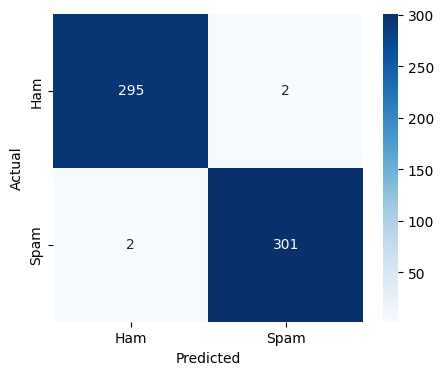

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predictions)
# Plot heatmap of confusion matrix with spam and not spam labels
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report

In [16]:
from sklearn.metrics import classification_report

report = classification_report(true_labels, predictions)
print(report)


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       297
           1       0.99      0.99      0.99       303

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600



# Saving the Model

In [ ]:
from datetime import date
today = date.today()
date_string = today.strftime("%d-%m-%Y")


# To save model train on a GPU
trained_models_dir = '/content/drive/MyDrive/trained_models'
model.save_pretrained(f'{trained_models_dir}/bert-email-spam-classifier_{date_string}')
tokenizer.save_pretrained(f'{trained_models_dir}/bert-email-spam-classifier_{date_string}')

('/content/drive/MyDrive/datasets/enron6/saved_bert_model_cuda/tokenizer_config.json',
 '/content/drive/MyDrive/datasets/enron6/saved_bert_model_cuda/special_tokens_map.json',
 '/content/drive/MyDrive/datasets/enron6/saved_bert_model_cuda/vocab.txt',
 '/content/drive/MyDrive/datasets/enron6/saved_bert_model_cuda/added_tokens.json')

# Loading the Saved Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [17]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model_path = f'/content/drive/MyDrive/trained_models/bert-email-spam-classifier_08-10-2024'

Using device: cuda


In [18]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

loaded_model = BertForSequenceClassification.from_pretrained(model_path)
loaded_tokenizer = BertTokenizer.from_pretrained(model_path)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

loaded_model.to(device)

Using device: cuda


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

# Make Predictions on new Data

In [19]:
def predict_spam_with_loaded_model(text):
    loaded_model.eval()
    inputs = loaded_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # Move inputs to GPU if available

    with torch.no_grad():
        logits = loaded_model(**inputs).logits
        prediction = torch.argmax(logits, dim=1).item()
    return 'Spam' if prediction == 1 else 'Not Spam'

In [17]:
# Example usage of the prediction function
print(predict_spam_with_loaded_model("Congratulations! You've won a free iPhone!"))
print(predict_spam_with_loaded_model("Subject: Meeting Re-Scheduled to 3 PM  Hi Everyone! Our meeting is rescheduled by 1 hr late sorry for the inconvenience..."))

Spam
Not Spam


# Predicting an original SPAM and Not Spam email

In [26]:
spam_email = '''
Subject: Urgent attention required for best work

Urgent attention required for best work
Services:

    Udyam (MSME) Registration
    Import Export Code (IEC) Registration
    FSSAI Registration
    Trade Mark Registration
    PF Registration & Return Filing
    GST Return Filing
    80G & 12A Registration
    NGO DARPAN
    ISO Registration
    Startup India Registration
    CSR Registration

Warm Regards
Name - SUMIT TIWARI
Mobile - 8750906680
'''

ham_email = '''
Subject: Workday maintenance window
Hi All,
I would like to inform you about an upcoming Workday maintenance window that will result in temporary system blackouts over the next few days.
'''

In [27]:
print(predict_spam_with_loaded_model(spam_email))
print(predict_spam_with_loaded_model(ham_email))

Spam
Not Spam


# Check the Memory Usage of the Model

In [28]:
# Display the number of parameters in the model
total_params = sum(p.numel() for p in loaded_model.parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 109483778


To calculate memory in bytes:

```Memory in bytes = Total no. of parameters * 4 bytes```

In [29]:
# Calculate the Memory Consumption of the Model
memory_consumption = total_params * 4
print(f'Memory Consumption: {memory_consumption} bytes')
print(f'Memory Consumption: {memory_consumption / (1024 ** 2):.2f} MB')
print(f'Memory Consumption: {memory_consumption / (1024 ** 3):.3f} GB')

Memory Consumption: 437935112 bytes
Memory Consumption: 417.65 MB
Memory Consumption: 0.408 GB


# Thanks for reading through...
 - Checkout my other projects on [GitHub](https://github.com/tapaswi-v-s/)
 - Connect with me on [LinkedIn](https://www.linkedin.com/in/tapaswi-v-s/)